In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tflearn

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


### Data loading and preprocessing

In [6]:
import tflearn.datasets.mnist as mnist
X, Y, testX, testY = mnist.load_data()

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


### Define parameter

In [14]:
tf.reset_default_graph()
image_dim = 28 * 28
z_dim = 128
total_samples = len(X)

### Define Generator and Discriminator

In [15]:
def generator(x, reuse=False):
    with tf.variable_scope("Generator", reuse=reuse):
        x = tflearn.fully_connected(x, 256, activation="relu")
        x = tflearn.fully_connected(x, image_dim, activation="sigmoid")
        return x

In [16]:
def discriminator(x, reuse=False):
    with tf.variable_scope("Discriminator", reuse=reuse):
        x = tflearn.fully_connected(x, 256, activation="relu")
        x = tflearn.fully_connected(x, 1, activation="sigmoid")
        return x

### Build Networks

In [17]:
gen_input = tflearn.input_data(shape=[None, z_dim], name="input_noise")
disc_input = tflearn.input_data(shape=[None, image_dim], name="disc_input")

`gen_sample`: input 128 → hidden 256 → fake_image 28 \* 28  
`disc_real`: real_image 28 \* 28 → hidden 256 → result 1  
`disc_fake`: fake_image 28 \* 28 → hidden 256 → result 1  

In [18]:
gen_sample = generator(gen_input)  # input 128 -> hidden 256 -> fake_image 28 * 28
disc_real = discriminator(disc_input)  # real_image 28 * 28 -> hidden 256 -> result 1
disc_fake = discriminator(gen_sample, reuse=True)  # fake_image 28 * 28 -> hidden 256 -> result 1

### Define Loss function
`loss`에 대한 수식은 [참고](https://github.com/golbin/TensorFlow-Tutorials/blob/master/07%20-%20GAN/01%20-%20GAN.py#L76:L89)

In [19]:
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1 - disc_fake))
gen_loss = -tf.reduce_mean(tf.log(disc_fake))

### Build training ops

In [20]:
gen_vars = tflearn.get_layer_variables_by_scope("Generator")
gen_model = tflearn.regression(gen_sample,
                              placeholder=None,
                              optimizer="adam",
                              loss=gen_loss,
                              trainable_vars=gen_vars,
                              batch_size=64,
                              name="target_gen",
                              op_name="GEN")

In [21]:
disc_vars = tflearn.get_layer_variables_by_scope("Discriminator")
disc_model = tflearn.regression(disc_real,
                              placeholder=None,
                              optimizer="adam",
                              loss=disc_loss,
                              trainable_vars=disc_vars,
                              batch_size=64,
                              name="target_disc",
                              op_name="DISC")

### Define GAN model
`output`: generated images

In [86]:
gan = tflearn.DNN(gen_model)

### Training

#### Generate noise

In [33]:
z = np.random.uniform(-1, 1, size=[total_samples, z_dim])
z.shape

(55000, 128)

#### Feed noise and real image
noise is converted to fake image

In [78]:
def sampling(ax, epoch):
    for i in range(sample_size):
        sample_z = np.random.uniform(-1, 1, size=[1, z_dim])
        ax[epoch][i].set_axis_off()
        _ = ax[epoch][i].imshow(gan.predict([sample_z]).flatten().reshape(28, 28),
                         cmap="gray",
                        interpolation="nearest")

Training Step: 8599  | time: 8.997s
| GEN | epoch: 010 | loss: 0.00000 -- iter: 54976/55000
| DISC | epoch: 010 | loss: 0.00000 -- iter: 54976/55000
Training Step: 8600  | time: 9.007s
| GEN | epoch: 010 | loss: 0.00000 -- iter: 55000/55000
| DISC | epoch: 010 | loss: 0.00000 -- iter: 55000/55000
--


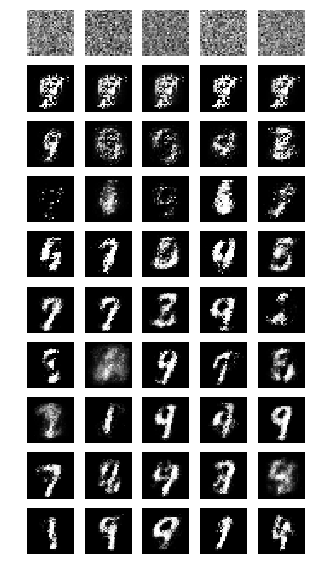

In [87]:
num_epoch = 10
sample_size = 5
fig, ax = plt.subplots(num_epoch, sample_size, figsize=(sample_size, num_epoch))

for epoch in range(num_epoch):
    sampling(ax, epoch)
    
    gan.fit(
        X_inputs={
            gen_input: z,
            disc_input: X
        },
        Y_targets=None,
        n_epoch=1
    )

plt.savefig("samples/total_sample_55000.png", bbox_inches="tight");
plt.show();